# NLP Tasks on GoEmotions
This notebook demonstrates multiple NLP tasks on the [GoEmotions dataset](https://huggingface.co/datasets/google-research-datasets/go_emotions) (simplified config). You will find:

1. **Data Exploration** (EDA) + SQL
2. **Visualization** of basic stats
3. **Preprocessing** (stemming, lemmatization, normalization, removing HTML, regex searching)
4. **Small subset + tokenization** demonstration
5. **Text Classification** (multi-label) with both scikit-learn + Keras
6. **Sentiment Analysis** (Transformer pipeline)
7. **Named Entity Recognition** (NER pipeline)
8. **Question Answering** (QA pipeline)
9. **Topic Modeling** (LDA)
10. **Word2Vec** (CBOW/Skip-gram) for word/sentence similarity and visualization

> **Important**: Some tasks (NER, QA) do not directly use the GoEmotions labels. We show them with **pretrained pipelines** for demonstration.

**Let's begin!**

In [2]:
%%capture
!pip install datasets nltk transformers sklearn matplotlib seaborn gensim sqlite3-bro


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppresses INFO and WARNING logs

import pandas as pd
import numpy as np
import re
import sqlite3

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
# If needed, uncomment:
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, f1_score

from skmultilearn.adapt import MLkNN

# Hugging Face Transformers
from transformers import pipeline

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalMaxPooling1D

# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation

# Word2Vec
import gensim
from gensim.models import Word2Vec

print("All packages imported!")

All packages imported!


## 1. Load GoEmotions (Simplified) + Basic EDA

In [2]:
from datasets import load_dataset

# Load the simplified GoEmotions dataset
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")
print(dataset)

# Convert to pandas DataFrame for easier handling
train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

print("\nTrain DataFrame:")
display(train_df.head())
print("\nValidation DataFrame:")
display(validation_df.head())
print("\nTest DataFrame:")
display(test_df.head())

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})

Train DataFrame:


,text,labels,id
0,My favourite food is anything I didn't have to...,[27],eebbqej
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj
3,To make her feel threatened,[14],ed7ypvh
4,Dirty Southern Wankers,[3],ed0bdzj



Validation DataFrame:


,text,labels,id
0,Is this in New Orleans?? I really feel like th...,[27],edgurhb
1,"You know the answer man, you are programmed to...","[4, 27]",ee84bjg
2,I've never been this sad in my life!,[25],edcu99z
3,The economy is heavily controlled and subsidiz...,"[4, 27]",edc32e2
4,He could have easily taken a real camera from ...,[20],eepig6r



Test DataFrame:


,text,labels,id
0,I’m really sorry about your situation :( Altho...,[25],eecwqtt
1,It's wonderful because it's awful. At not with.,[0],ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",[13],een27c3
3,"I didn't know that, thank you for teaching me ...",[15],eelgwd1
4,They got bored from haunting earth for thousan...,[27],eem5uti


### 1.1 Basic SQL Exploration

In [24]:
# Create in-memory SQLite for train_df
conn = sqlite3.connect(':memory:')
train_df_str = train_df.applymap(str)
train_df_str.to_sql('emotions', conn, if_exists='replace', index=False)

# 1) Label distribution (top 5)
query_label_distribution = """
SELECT 
    labels, COUNT(*) as count_labels 
FROM emotions 
GROUP BY labels 
ORDER BY count_labels DESC 
LIMIT 5;
"""
result_df = pd.read_sql_query(query_label_distribution, conn)
print("Label Distribution (Top 5):")
display(result_df)

# 2) Find texts containing a digit
# query_numbers = """
# SELECT text
# FROM emotions
# WHERE text LIKE '%[0-9]%'
# LIMIT 5;
# """
query = """
SELECT text
FROM emotions
WHERE text LIKE '%sad%'
LIMIT 5;
"""

# numbers_df = pd.read_sql_query(query_numbers, conn)
response_df = pd.read_sql_query(query, conn)
# print("\nTexts containing digits (first 5):")
print(f"query : {query}")
print("\nTexts containing query pattern (first 5):")
display(response_df)
print(f"First value of response: {response_df['text'][0]}")

Label Distribution (Top 5):


,labels,count_labels
0,[27],12823
1,[0],2710
2,[4],1873
3,[15],1857
4,[1],1652


query : 
SELECT text
FROM emotions
WHERE text LIKE '%sad%'
LIMIT 5;


Texts containing query pattern (first 5):


,text
0,Go pursue that education. Let [NAME] wallow in...
1,Sad. My condolences to her family.
2,"I'm curious to see the difference, but sadly t..."
3,Emotes have a ridiculous amount of effort put ...
4,"The sad thing is, relatively speaking these ar..."


First value of response: Go pursue that education. Let [NAME] wallow in her own sadness.


## 2. Data Visualization
Let's see how many labels each sample has.

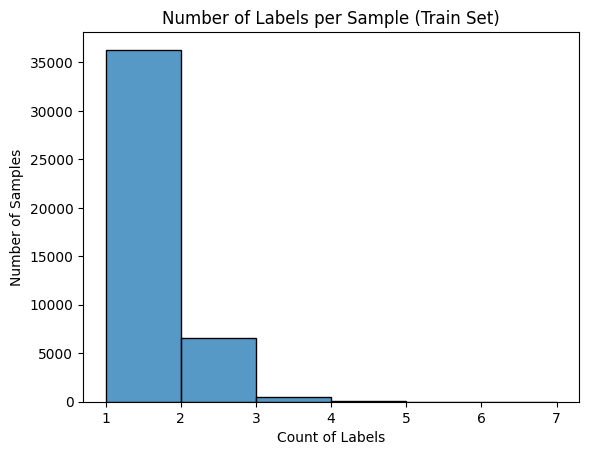

In [4]:
train_label_counts = train_df['labels'].apply(len)
sns.histplot(train_label_counts, bins=range(1,8), kde=False)
plt.title("Number of Labels per Sample (Train Set)")
plt.xlabel("Count of Labels")
plt.ylabel("Number of Samples")
plt.show()

## 3. Preprocessing the Text
We'll demonstrate several steps:
1. Stemming
2. Lemmatization
3. Normalization
4. Removing HTML tags
5. Finding patterns with regex (numbers, emails)

In [5]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text

def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# We'll create a small demonstration subset
demo_df = train_df.sample(5, random_state=42).copy()

# Stemming
demo_df['stemmed'] = demo_df['text'].apply(
    lambda x: ' '.join(stemmer.stem(word) for word in x.split())
)

# Lemmatization
demo_df['lemmatized'] = demo_df['text'].apply(
    lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split())
)

# Normalization + HTML removal example
demo_df['html_example'] = "<p>I am <strong>Happy</strong> 123!</p>"
demo_df['cleaned_html'] = demo_df['html_example'].apply(remove_html_tags).apply(normalize_text)

# Pattern searching
demo_df['contains_numbers'] = demo_df['text'].str.contains(r'\d', na=False)
demo_df['contains_email'] = demo_df['text'].str.contains(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\\.[a-zA-Z]{2,}', na=False)

demo_df

,text,labels,id,stemmed,lemmatized,html_example,cleaned_html,contains_numbers,contains_email
25759,The only way this works is if [NAME] is doing ...,[27],edupnyh,the onli way thi work is if [name] is do the b...,The only way this work is if [NAME] is doing t...,<p>I am <strong>Happy</strong> 123!</p>,i am happy 123,False,False
22531,Access should be hindered it's getting destroyed.,[3],ediy7lp,access should be hinder it' get destroyed.,Access should be hindered it's getting destroyed.,<p>I am <strong>Happy</strong> 123!</p>,i am happy 123,False,False
18418,Totally fair. All I was trying to remind every...,[4],edv791a,total fair. all i wa tri to remind everyon is ...,Totally fair. All I wa trying to remind everyo...,<p>I am <strong>Happy</strong> 123!</p>,i am happy 123,False,False
31117,"I'm poly and jn the Raleigh area too, moved he...",[26],ed8lzbw,"i'm poli and jn the raleigh area too, move her...","I'm poly and jn the Raleigh area too, moved he...",<p>I am <strong>Happy</strong> 123!</p>,i am happy 123,False,False
5733,Naw man Asain men have an easier time. Most of...,[1],edlvvfv,naw man asain men have an easier time. most of...,Naw man Asain men have an easier time. Most of...,<p>I am <strong>Happy</strong> 123!</p>,i am happy 123,False,False


## 4. Show a Small Subset & Tokenize

In [6]:
subset_df = train_df.sample(5, random_state=123).copy()
print("Subset of original text:\n", subset_df['text'])

# Tokenize using NLTK
subset_df['tokenized'] = subset_df['text'].apply(nltk.word_tokenize)
print("\nSubset with tokenized texts:\n", subset_df[['text', 'tokenized']])

Subset of original text:
 40694                                    You are unhinged.
25582    People need to want democracy in its raw form ...
29683    Underrated comment, my friend! Know that you m...
26227                                    Are you ghosting?
6247                                              ~ [NAME]
Name: text, dtype: object

Subset with tokenized texts:
                                                     text  \
40694                                  You are unhinged.   
25582  People need to want democracy in its raw form ...   
29683  Underrated comment, my friend! Know that you m...   
26227                                  Are you ghosting?   
6247                                            ~ [NAME]   

                                               tokenized  
40694                            [You, are, unhinged, .]  
25582  [People, need, to, want, democracy, in, its, r...  
29683  [Underrated, comment, ,, my, friend, !, Know, ...  
26227                    

## 5. Text Classification
We have 28 possible emotion labels, meaning multi-label classification.

### 5.1 Multi-Label with scikit-learn (Logistic Regression)

#### 5.1.1 Data Preprocessing

In [7]:
# 1) Binarize the labels
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_df['labels'])
y_val   = mlb.transform(validation_df['labels'])
y_test  = mlb.transform(test_df['labels'])

print("Number of classes:", len(mlb.classes_))
print("Classes:", mlb.classes_)

# 2) TF-IDF vectorize the text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_df['text'])
X_val_tfidf   = vectorizer.transform(validation_df['text'])
X_test_tfidf  = vectorizer.transform(test_df['text'])

Number of classes: 28
Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


#### 5.1.2 Classification using a binary/multiclass model with OneVsRest technique 

##### Using Logistic Regression:

In [8]:

# LogisticRegression in a OneVsRest scheme
model = LogisticRegression()
model_sklearn = OneVsRestClassifier(model)
model_sklearn.fit(X_train_tfidf, y_train)

# Evaluate on Validation
print(f"======== Performance Evaluation of {type(model).__name__} ========")
y_val_pred = model_sklearn.predict(X_val_tfidf)
print("Classification Report on Validation Data:")
# print(classification_report(y_val, y_val_pred, zero_division=0))
report_dict = classification_report(y_val, y_val_pred, zero_division=0, 
                                    target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df[-4:])

# Evaluate on Test
y_test_pred = model_sklearn.predict(X_test_tfidf)
print("\nClassification Report on Test Data:")
# print(classification_report(y_test, y_test_pred, zero_division=0))
report_dict = classification_report(y_test, y_test_pred, zero_division=0, 
                                    target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df[-4:])

======== Performance Evaluation of LogisticRegression ========
Classification Report on Validation Data:
              precision    recall  f1-score  support
micro avg      0.711908  0.301724  0.423822   6380.0
macro avg      0.611302  0.180607  0.247914   6380.0
weighted avg   0.667053  0.301724  0.374989   6380.0
samples avg    0.340183  0.322752  0.326662   6380.0

Classification Report on Test Data:
              precision    recall  f1-score  support
micro avg      0.706574  0.303997  0.425099   6329.0
macro avg      0.592282  0.173867  0.237783   6329.0
weighted avg   0.678376  0.303997  0.375844   6329.0
samples avg    0.342669  0.325011  0.328985   6329.0


#### 5.1.2 Classification directly with a multilabel classifier

#### 5.1.2.1 Using a scikit learn model that directly supports multilabel classification: 

In [9]:
model_sklearn = RandomForestClassifier(n_estimators = 100, random_state=42)  
# model_sklearn = OneVsRestClassifier(model)
model_sklearn.fit(X_train_tfidf, y_train)

# Evaluate on Validation
print(f"======== Performance Evaluation of {type(model_sklearn).__name__} ========")
y_val_pred = model_sklearn.predict(X_val_tfidf)
print("Classification Report on Validation Data:")
# print(classification_report(y_val, y_val_pred, zero_division=0))
report_dict = classification_report(y_val, y_val_pred, zero_division=0, 
                                    target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df[-4:])

# Evaluate on Test
y_test_pred = model_sklearn.predict(X_test_tfidf)
print("\nClassification Report on Test Data:")
# print(classification_report(y_test, y_test_pred, zero_division=0))
report_dict = classification_report(y_test, y_test_pred, zero_division=0, 
                                    target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df[-4:])

======== Performance Evaluation of RandomForestClassifier ========
Classification Report on Validation Data:
              precision    recall  f1-score  support
micro avg      0.687718  0.339655  0.454727   6380.0
macro avg      0.595954  0.174312  0.229670   6380.0
weighted avg   0.666008  0.339655  0.383856   6380.0
samples avg    0.395780  0.368980  0.377264   6380.0

Classification Report on Test Data:
              precision    recall  f1-score  support
micro avg      0.675763  0.328646  0.442224   6329.0
macro avg      0.639603  0.169536  0.223173   6329.0
weighted avg   0.691945  0.328646  0.370529   6329.0
samples avg    0.379737  0.354969  0.362742   6329.0


#### 5.1.2.2 Using a scikit learn model that directly supports multilabel classification: 

##### Using a Scikit Multilearn model:

In [10]:
# multilabel k nearest neighbor
model = MLkNN(k=5)
model.fit(X_train_tfidf, y_train)

# Evaluate on Validation
print(f"======== Performance Evaluation of {type(model).__name__} ========")
y_val_pred = model.predict(X_val_tfidf)
print("Classification Report on Validation Data:")
# print(classification_report(y_val, y_val_pred, zero_division=0))
report_dict = classification_report(y_val, y_val_pred, zero_division=0, 
                                    target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df[-4:])

# Evaluate on Test
y_test_pred = model.predict(X_test_tfidf)
print("\nClassification Report on Test Data:")
# print(classification_report(y_test, y_test_pred, zero_division=0))
report_dict = classification_report(y_test, y_test_pred, zero_division=0, 
                                    target_names=mlb.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df[-4:])

======== Performance Evaluation of MLkNN ========
Classification Report on Validation Data:
              precision    recall  f1-score  support
micro avg      0.355248  0.140596  0.201460   6380.0
macro avg      0.294990  0.115196  0.156705   6380.0
weighted avg   0.362593  0.140596  0.196347   6380.0
samples avg    0.142723  0.149189  0.141299   6380.0

Classification Report on Test Data:
              precision    recall  f1-score  support
micro avg      0.362385  0.137304  0.199152   6329.0
macro avg      0.325017  0.124963  0.164640   6329.0
weighted avg   0.374172  0.137304  0.193777   6329.0
samples avg    0.138769  0.144202  0.137406   6329.0


### 5.2 Multi-Label with Deep Learning (Keras + LSTM)

In [11]:
# Tokenize + pad sequences
tokenizer = Tokenizer(num_words=5000, oov_token='<UNK>')
tokenizer.fit_on_texts(train_df['text'])

X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_val_seq   = tokenizer.texts_to_sequences(validation_df['text'])
X_test_seq  = tokenizer.texts_to_sequences(test_df['text'])

max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=max_len, padding='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post')

num_classes = y_train.shape[1]
vocab_size  = 5000

model_keras = Sequential()
model_keras.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model_keras.add(LSTM(128, return_sequences=True))
model_keras.add(GlobalMaxPooling1D())
model_keras.add(Dense(128, activation='relu'))
model_keras.add(Dense(num_classes, activation='sigmoid'))  # multi-label -> sigmoid

model_keras.compile(optimizer='adam',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

history = model_keras.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    # epochs=3,
    epochs=5,
    batch_size=32
)

# Evaluate on test
test_loss, test_acc = model_keras.evaluate(X_test_pad, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# More detailed metrics
y_test_pred_proba = model_keras.predict(X_test_pad)
y_test_pred_bin = (y_test_pred_proba >= 0.5).astype(int)

print("\nTest Classification Report (threshold=0.5):")
print(classification_report(y_test, y_test_pred_bin, zero_division=0))

Epoch 1/5
1357/1357 [==============================] - 90s 54ms/step - loss: 0.1375 - accuracy: 0.3859 - val_loss: 0.1142 - val_accuracy: 0.4847
Epoch 2/5
1357/1357 [==============================] - 70s 51ms/step - loss: 0.1050 - accuracy: 0.5060 - val_loss: 0.1003 - val_accuracy: 0.5252
Epoch 3/5
1357/1357 [==============================] - 73s 54ms/step - loss: 0.0938 - accuracy: 0.5426 - val_loss: 0.0969 - val_accuracy: 0.5381
Epoch 4/5
1357/1357 [==============================] - 72s 53ms/step - loss: 0.0871 - accuracy: 0.5704 - val_loss: 0.0964 - val_accuracy: 0.5363
Epoch 5/5
170/170 [==============================] - 4s 23ms/step - loss: 0.0975 - accuracy: 0.5292

Test Loss: 0.0975
Test Accuracy: 0.5292
170/170 [==============================] - 4s 17ms/step

Test Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.70      0.47      0.56       504
           1       0.82      0.71      0.76       264
           2   

## 6. Sentiment Analysis (Transformers Pipeline)
Although GoEmotions is multi-label, we can show a pretrained **sentiment-analysis** pipeline (e.g., DistilBERT on SST-2).

In [12]:
# sample_texts = [
#     "I love this! It's absolutely fantastic.",
#     "I hate everything about this situation.",
#     "I'm feeling okay, nothing special."
# ]

sample_texts = train_df['text'].sample(3, random_state=42).tolist()
print(f"\nSample Texts: {sample_texts}")

sentiment_pipeline = pipeline("sentiment-analysis")
print("\nSentiment Analysis Result with default pipeline:")
for txt in sample_texts:
    result = sentiment_pipeline(txt)
    print(txt, "->", result)
print()

model_name = "finiteautomata/bertweet-base-sentiment-analysis"
sentiment_pipeline = pipeline(model=model_name)
print(f"\nSentiment Analysis Result with {model_name}:")
for txt in sample_texts:
    result = sentiment_pipeline(txt)
    print(txt, "->", result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.



Sample Texts: ['The only way this works is if [NAME] is doing the Bird Box challenge and cant see the terms of the contract.', "Access should be hindered it's getting destroyed.", "Totally fair. All I was trying to remind everyone is don't fall in love with your crushes."]


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Sentiment Analysis Result with default pipeline:
The only way this works is if [NAME] is doing the Bird Box challenge and cant see the terms of the contract. -> [{'label': 'NEGATIVE', 'score': 0.9993564486503601}]
Access should be hindered it's getting destroyed. -> [{'label': 'NEGATIVE', 'score': 0.9996906518936157}]
Totally fair. All I was trying to remind everyone is don't fall in love with your crushes. -> [{'label': 'POSITIVE', 'score': 0.9991602897644043}]



emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Sentiment Analysis Result with finiteautomata/bertweet-base-sentiment-analysis:
The only way this works is if [NAME] is doing the Bird Box challenge and cant see the terms of the contract. -> [{'label': 'NEG', 'score': 0.5374358296394348}]
Access should be hindered it's getting destroyed. -> [{'label': 'NEG', 'score': 0.9623880386352539}]
Totally fair. All I was trying to remind everyone is don't fall in love with your crushes. -> [{'label': 'NEU', 'score': 0.871118426322937}]


## 7. Named Entity Recognition

In [16]:
ner_pipeline = pipeline("ner", grouped_entities=True)
# demo_sentence = "Barack Obama was born in Hawaii and became the President of the United States."
demo_sentence = train_df['text'].sample(1, random_state=42).tolist()[0]
ner_results = ner_pipeline(demo_sentence)
print()
print("Given sentence:", demo_sentence)
print("Named Entity REcognition Results with default model:", ner_results)
model_name = "dslim/bert-base-NER"
ner_pipeline = pipeline("ner", model_name, grouped_entities=True)
ner_results = ner_pipeline(demo_sentence)
print(f"\nNamed Entity REcognition Results with with {model_name}:", ner_results)

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision 4c53496 (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Given sentence: The only way this works is if [NAME] is doing the Bird Box challenge and cant see the terms of the contract.
Named Entity REcognition Results with default model: [{'entity_group': 'ORG', 'score': 0.9922839, 'word': 'NAME', 'start': 31, 'end': 35}, {'entity_group': 'MISC', 'score': 0.942708, 'word': 'Bird Box', 'start': 50, 'end': 58}]


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Named Entity REcognition Results with with dslim/bert-base-NER: [{'entity_group': 'ORG', 'score': 0.839247, 'word': 'NAME', 'start': 31, 'end': 35}, {'entity_group': 'ORG', 'score': 0.66656935, 'word': 'Bird Box', 'start': 50, 'end': 58}]


## 8. Question Answering

In [17]:
qa_pipeline = pipeline("question-answering")

context = """Hugging Face Inc. is a company based in New York City.\n\
It is famous for its transformers library that provides \n\
state-of-the-art machine learning models."""

question = "Where is Hugging Face Inc. based?"
qa_result = qa_pipeline(question=question, context=context)
print()
print("Question:", question)
print("Answer:", qa_result['answer'], "| Score:", qa_result['score'])

No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Question: Where is Hugging Face Inc. based?
Answer: New York City | Score: 0.9869067668914795


## 9. Topic Modeling with LDA
We'll use a **CountVectorizer** and **LatentDirichletAllocation** on a subset of the data to discover topics.

In [18]:
# Use a subset for demonstration
small_corpus = train_df['text'].sample(2000, random_state=42).tolist()

count_vec = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_counts = count_vec.fit_transform(small_corpus)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_counts)

# feature_names = count_vec.get_feature_names_out()
feature_names = count_vec.get_feature_names()

def display_topics(model, feature_names, num_top_words=10):
    for idx, topic in enumerate(model.components_):
        top_features_idx = topic.argsort()[-num_top_words:]
        top_features = [feature_names[i] for i in top_features_idx]
        print(f"Topic {idx}: {' '.join(top_features)}")

display_topics(lda, feature_names)

Topic 0: time great sounds wow damn people just hope really like
Topic 1: just thanks feel really like ve thank people think don
Topic 2: happy man thanks luck work did nice bad years good
Topic 3: little comment yeah oh yes know ll right lol love
Topic 4: game lol fucking going got don hate love great just


## 10. Word2Vec (CBOW/Skip-gram)
Train a small model or load a pretrained one, then compute **word similarity** and **sentence similarity**, plus a **t-SNE** visualization.

### 10.1 Word Similarity:

In [19]:
# Sample a subset for training a small Word2Vec model
train_corpus = [nltk.word_tokenize(t.lower()) for t in train_df['text'].sample(5000, random_state=42)]

# Train Word2Vec (CBOW if sg=0)
w2v_model = Word2Vec(sentences=train_corpus, vector_size=100, window=5, min_count=2, workers=4, sg=0)

# Example: most similar to "happy"
if "happy" in w2v_model.wv:
    similar_to_happy = w2v_model.wv.most_similar("happy", topn=5)
    print("Most similar words to 'happy':")
    for word, score in similar_to_happy:
        print(f"{word}: {score:.4f}")
else:
    print("'happy' not in vocabulary.")

Most similar words to 'happy':
your: 0.9993
been: 0.9992
enough: 0.9992
need: 0.9991
work: 0.9991


### 10.2 Sentence Similarity:

In [22]:
def sentence_embedding(sentence, model):
    tokens = nltk.word_tokenize(sentence.lower())
    vecs = []
    for w in tokens:
        if w in model.wv:
            vecs.append(model.wv[w])
    if len(vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)

def cosine_similarity(v1, v2):
    dot = np.dot(v1, v2)
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    return dot / (norm1 * norm2)

s1 = "I am very happy today!"
s2 = "What a wonderful day!"
v1 = sentence_embedding(s1, w2v_model)
v2 = sentence_embedding(s2, w2v_model)
print(f"Sentence 1: {s1}")
print(f"Sentence 2: {s2}")
print(f"Similarity between them: {cosine_similarity(v1, v2):.4f}")
print()
s1 = "I am very happy today!"
s2 = "What a wonderful day!"
v1 = sentence_embedding(s1, w2v_model)
v2 = sentence_embedding(s2, w2v_model)
print(f"Sentence 1: {s1}")
print(f"Sentence 2: {s2}")
print(f"Similarity between them: {cosine_similarity(v1, v2):.4f}")

Sentence 1: I am very happy today!
Sentence 2: What a wonderful day!
Similarity between them: 0.9993


#### 10.2.1 SQL Query two distinct sentences and then find sentence similarity:

In [27]:
""" Query two distinct sentences from the dataset (e.g., from 'emotions' table in the SQLite db).
    Let's assume we still have 'conn' for  SQLite connection and 'w2v_model' already trained.
"""

query = """
SELECT text 
FROM emotions 
LIMIT 2;
"""
response_df = pd.read_sql_query(query, conn)

# 2) Extract those two sentences
s1 = response_df.loc[0, 'text']
s2 = response_df.loc[1, 'text']

# 3) Embed and calculate similarity
v1 = sentence_embedding(s1, w2v_model)
v2 = sentence_embedding(s2, w2v_model)

print(f"query for finding two distinct sentences: {query}")
print(f"Sentence 1: {s1}")
print(f"Sentence 2: {s2}")
print(f"Similarity between them: {cosine_similarity(v1, v2):.4f}")


query for finding two distinct sentences: 
SELECT text 
FROM emotions 
LIMIT 2;

Sentence 1: My favourite food is anything I didn't have to cook myself.
Sentence 2: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Similarity between them: 0.9997


### 10.3 t-SNE visualization of some selected words:

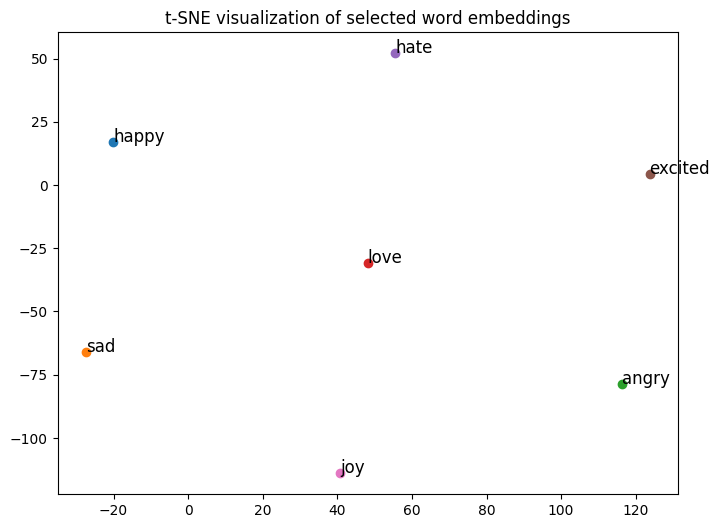

In [28]:
# t-SNE visualization of some selected words
from sklearn.manifold import TSNE

words_to_plot = ["happy", "sad", "angry", "love", "hate", "excited", "joy", "bored"]
available_words = [w for w in words_to_plot if w in w2v_model.wv]

if len(available_words) < 2:
    print("Not enough words in vocabulary for visualization.")
else:
    word_vectors = [w2v_model.wv[w] for w in available_words]
    tsne = TSNE(n_components=2, random_state=42)
    embeds_2d = tsne.fit_transform(word_vectors)

    plt.figure(figsize=(8,6))
    for i, word in enumerate(available_words):
        x, y = embeds_2d[i,0], embeds_2d[i,1]
        plt.scatter(x, y, marker='o')
        plt.text(x+0.01, y+0.01, word, fontsize=12)
    plt.title("t-SNE visualization of selected word embeddings")
    plt.show()

In [29]:
# Close the database connection
conn.close()

# 11. Conclusion
In this notebook We have:
1. Explored GoEmotions data with **SQL** and visualizations.
2. Demonstrated **preprocessing** (stemming, lemmatization, normalization, HTML removal, regex pattern search).
3. Shown a **subset** and **tokenized** texts.
4. Built **multi-label classification** models using **Logistic Regression** (scikit-learn) and **Keras** (LSTM).
5. Demonstrated **sentiment analysis**, **NER**, and **QA** with pretrained **Transformers pipelines**.
6. Performed **topic modeling** (LDA).
7. Showed **Word2Vec** training and embeddings for word/sentence similarity and 2D visualization.


# 12. References:

- https://github.com/tatsath/fin-ml/blob/master/Chapter%2010%20-%20Natural%20Language%20Processing/NLP-MasterTemplate.ipynb

- https://github.com/TirendazAcademy/Hugging-Face-Tutorials/blob/main/Emotion-Analysis-with-Hugging-Face.ipynb

- https://github.com/odenipinedo/Python/blob/master/datacamp/introduction%20to%20natural%20language%20processing%20in%20Python.ipynb

- https://github.com/emrulk1/AI-ML-Data-Science-Practice/blob/main/Natural_Language_Processing/nlp_libraries.ipynb

- https://cocalc.com/github/YStrano/DataScience_GA/blob/master/lessons/lesson_13/natural-language-processing%20NLP%20(done).ipynb

- https://github.com/emrulk1/AI-ML-Data-Science-Practice/blob/main/MSCSE_Coursework/Machine_Learning/StackOverflow_Question_Tag_classification.ipynb

- https://github.com/emrulk1/AI-ML-Data-Science-Practice/blob/main/Natural_Language_Processing/Text_Preprocessing_and_Vectorization/Text_Preprocessing.ipynb